In [2]:
#

import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
import matplotlib.ticker as mticker
#data
#load portfolio tickers
port_df = pd.read_csv('equity_names.csv', index_col = None)
#port_df['bbg_ticker']= port_df.apply(lambda x: str(x['name'])+' US Equity', axis = 1)

#port_df['Date']= pd.to_datetime(port_df['Date'])
#port_df.set_index('Date', inplace = True)

In [37]:
data_master = pd.DataFrame()
for ticker in tickers:
    data = blp.bdh(tickers=ticker
             , flds=['SHORT_INT',
                    'PX_LAST',
                    'PX_VOLUME',
                    'VOLUME_AVG_10D',
                    'VOLUME_AVG_30D',
                    'VOLUME_AVG_60D',
                    'VOLATILITY_10D',
                    'VOLATILITY_30D',
                    'VOLATILITY_60D',
                    'CALL_IMP_VOL_10D',
                    'CALL_IMP_VOL_30D',
                    'CALL_IMP_VOL_60D',
                    'VOLUME_TOTAL_CALL',
                    'OPEN_INT_TOTAL_CALL',
                    'VOLUME_TOTAL_PUT',
                    'OPEN_INT_TOTAL_PUT',
                    'PUT_CALL_OPEN_INTEREST_RATIO',
                    'PUT_CALL_OPEN_INTEREST_TOTAL'
                        ],
             start_date= start_date, end_date=end_date,Per='D')
    data.index.names = ['date']
    data.index = data.index#.strftime('%d/%m/%Y')
    data.columns = data.columns.droplevel(0)
    data['VOLUME_AVG_10D'] = data['PX_VOLUME'].rolling(window=10).mean()
    data['VOLUME_AVG_30D'] = data['PX_VOLUME'].rolling(window=30).mean()
    data['VOLUME_AVG_60D'] = data['PX_VOLUME'].rolling(window=60).mean()
    data['Ticker'] = ticker
    data_master = pd.concat([data_master,data])
    
data_master.reset_index(inplace = True) 

In [63]:
#join stock_borrow_data data
sbl_data = pd.read_csv('stock_borrow_data.csv', index_col = None)
sbl_data['Date']= pd.to_datetime(sbl_data['Date'])
data_master['date']= pd.to_datetime(data_master['date'])
data_master = pd.merge(data_master,sbl_data, left_on = ['date','Ticker'], right_on = ['Date','BBG Ticker'])

,date,SHORT_INT,PX_LAST,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,VOLATILITY_60D,CALL_IMP_VOL_10D,CALL_IMP_VOL_30D,CALL_IMP_VOL_60D,...,Average Age of Loans (days),Avg Rebate (inclusive of FF),New Rebate (inclusive of FF),Avg Fee (exclusive of FF),New Fee (exclusive of FF),Returned Shares,Avg Age of Returned Loans,Returned %,Age Return Ratio,# of Loan Contracts
0,2023-09-18,NaN,58.00,34571903.0,NaN,NaN,NaN,54.196,54.196,54.525,...,0.0000,-3.6364,-3.6364,6.5217,6.5217,NaN,NaN,0.000000,2.436647,95
1,2023-09-19,NaN,55.17,18308644.0,NaN,NaN,NaN,52.337,52.337,53.120,...,0.4104,-0.7340,-0.9565,1.3025,1.0000,"1,864,500",1.0000,0.211200,NaN,137
2,2023-09-20,NaN,52.91,16369470.0,192.303,NaN,NaN,53.824,53.824,54.057,...,0.2713,0.0552,0.0804,4.5530,4.6837,"5,642,710",1.6000,0.403703,5.897530,139
3,2023-09-21,NaN,52.16,15010920.0,172.589,NaN,NaN,56.969,55.376,55.670,...,0.8067,1.1308,1.3511,4.1739,2.6213,"5,080,974",1.2534,0.362286,1.553737,147
4,2023-09-22,NaN,51.32,8430168.0,158.022,NaN,NaN,55.847,55.788,56.382,...,1.1486,2.0798,2.4720,3.8609,1.8622,"5,509,877",1.6041,0.350861,1.396570,167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300,2024-04-26,NaN,19.43,39397292.0,78.622,88.971,124.534,107.556,109.628,114.479,...,32.2673,5.1498,5.0735,0.1979,0.3250,4550047,5.6030,0.066058,0.173643,595
2301,2024-04-29,NaN,18.03,40382671.0,90.456,91.738,125.458,108.718,109.760,112.181,...,35.2828,5.1527,5.0966,0.2030,0.3633,2453887,9.1430,0.036082,0.259135,588
2302,2024-04-30,NaN,16.06,42086991.0,117.583,97.801,126.408,116.898,111.783,113.477,...,36.2312,5.1636,5.0534,0.2049,0.2734,3916972,16.2084,0.057971,0.447360,568
2303,2024-05-01,NaN,16.07,38827757.0,117.225,85.145,126.291,114.617,113.359,112.964,...,36.7111,5.1617,5.0223,0.2055,0.2312,1446626,9.4611,0.021226,0.257718,616


In [80]:
import numpy as np
from sklearn.linear_model import LinearRegression
#set up regression here 
model = LinearRegression()

volume = data_master[data_master['Ticker']=='TLRY US Equity'][['PX_VOLUME']]
price = data_master[data_master['Ticker']=='TLRY US Equity'][['PX_LAST']]

model.fit(volume, price)
model = LinearRegression().fit(volume, price)

r_sq = model.score(volume, price)
print(f"coefficient of determination: {r_sq}")


coefficient of determination: 0.21327926272008757


In [87]:
print(f"intercept: {model.intercept_}")

print(f"slope: {model.coef_}")
y_pred = model.predict([[0.1],[0.6]])
print(f"predicted_value:  {y_pred}")
#y_pred = model.predict(x)

intercept: [1.83723634]
slope: [[8.57602999e-09]]
predicted_value:  [[1.83723634]
 [1.83723635]]


C:\Program Files\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


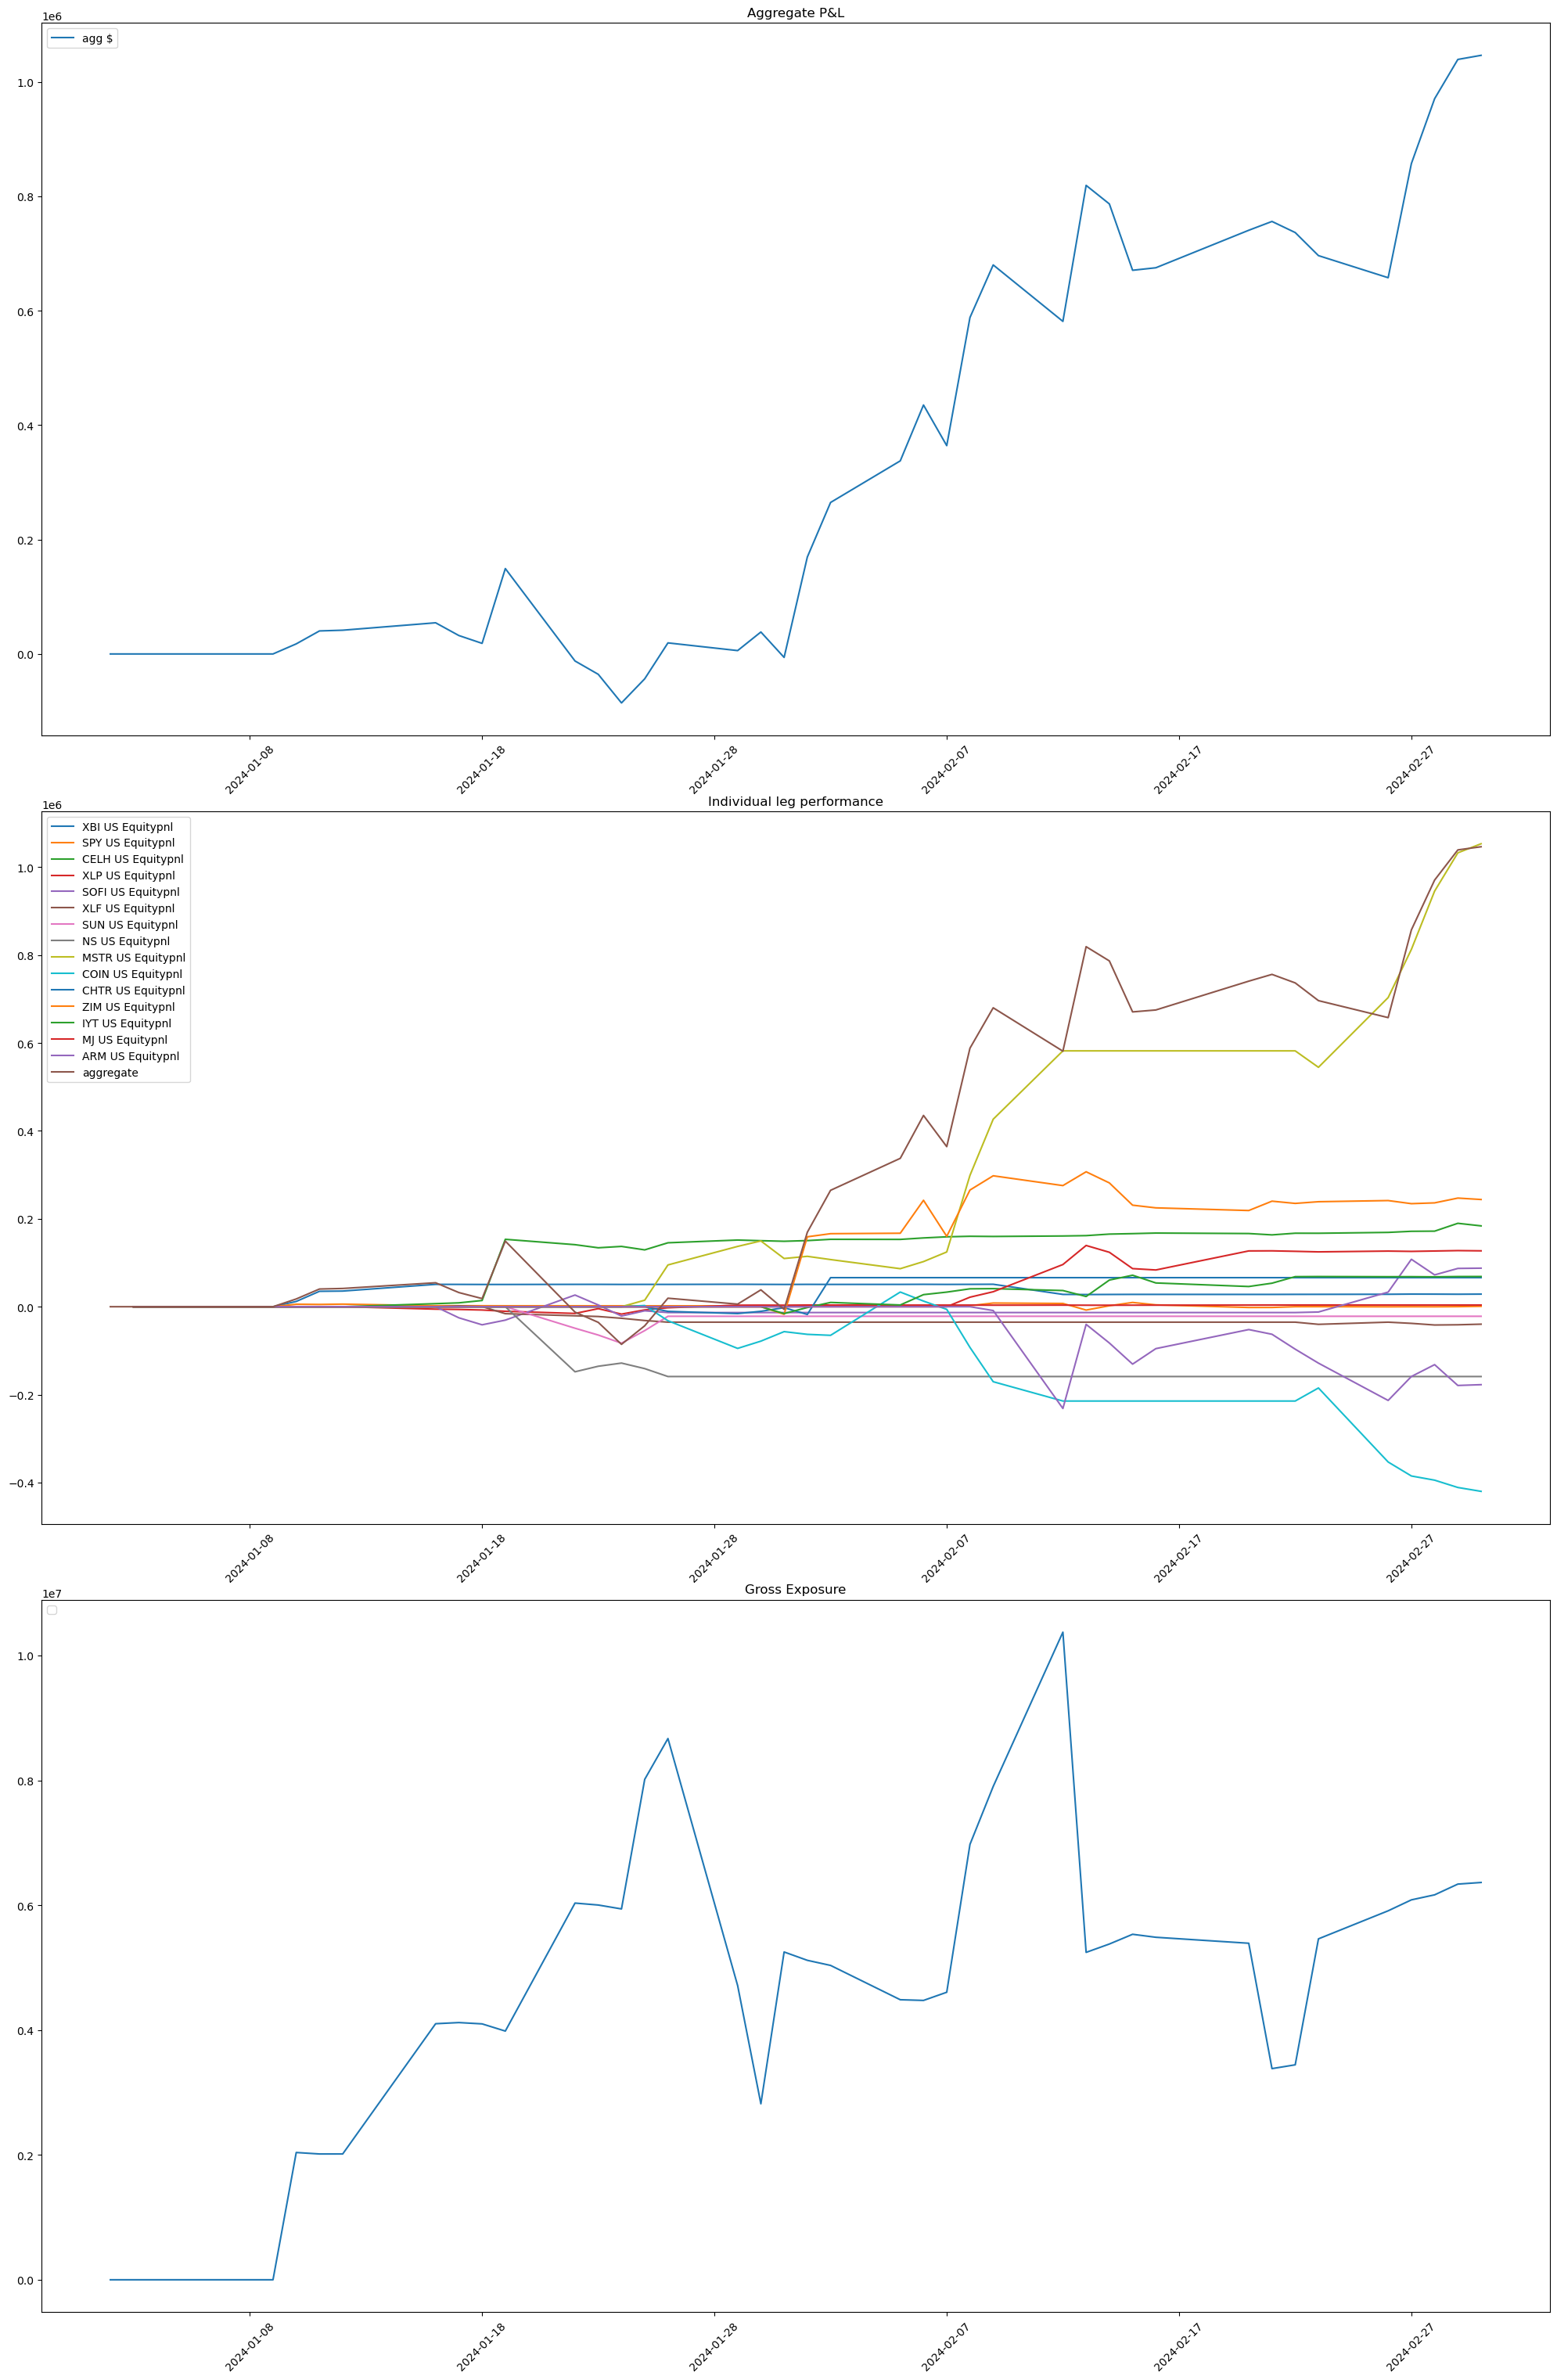

In [94]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20, 30))
ax[0].set_title("Aggregate P&L")
ax[0].plot(df_returns['aggregate'].cumsum() ,label ='agg $');
loc = plticker.MultipleLocator(base=10)
ax[0].legend(loc="upper left",prop={'size': 10})
ax[0].xaxis.set_major_locator(loc)
ax[0].tick_params(axis='x', rotation=45)
plt.tight_layout()

ax[1].set_title("Individual leg performance")
ax[1].plot(df_returns.cumsum(), label =df_returns.columns );

#ax.axhline(y=round(PC3param.gamma,2), color='r', linestyle = '--');
#ax.plot(df['principal component 3'], 'b', label ='PC3(curve)');
loc = plticker.MultipleLocator(base=10)
ax[1].legend(loc="upper left",prop={'size': 10})
ax[1].xaxis.set_major_locator(loc)
ax[1].tick_params(axis='x', rotation=45)

ax[2].set_title("Gross Exposure")
ax[2].plot(df_exposure['abs_exposure']);#, label =df_exposure.columns );
ax[2].legend(loc="upper left",prop={'size': 10})
ax[2].xaxis.set_major_locator(loc)
ax[2].tick_params(axis='x', rotation=45)